<a href="https://colab.research.google.com/github/JohnMorrisonn/DS-Unit-2-Kaggle-Challenge/blob/master/module1/221_Assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [X] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```



In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.0)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
Already up to date.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
X_train, X_val, y_train, y_val= train_test_split(train, train['status_group'], test_size=0.25, train_size=0.75, stratify=train['status_group'])

In [4]:
X_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [0]:
def wrangle(X):
    X = X.copy()

    X['date_recorded'] = pd.to_datetime(X['date_recorded']).dt.year

    numeric = X.select_dtypes(include='number').columns.drop(['id', 'region_code', 'num_private']).tolist()

    categories = ['quantity', 'extraction_type']

    features = numeric + categories

    X = X[features]

    X['longitude'] = X['longitude'].replace(0, 33.4)
    X['latitude'] = X['latitude'].replace(2e-8, -3)

    return X

X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(test) 

In [0]:
X_train['latitude'].describe()

In [0]:
# zero_lon = X_train['longitude'] < 1

# shin_lon_mean = X_train[(X_train['longitude'] > 1) & (X_train['region'] == 'Shinyanga')]['longitude'].mean()

# Shinyanga = X_train['region'] == 'Shinyanga'
# Mwanza = X_train['region'] == 'Mwanza'

# X_train[zero_lon].apply(lambda x: shin_lon_mean)



In [6]:
# null = train.columns[train.isnull().any()]
# X_train[null]

KeyError: ignored

In [0]:
# def relative_freq_fcat_by_tcat(df, f_cat, t_cat, verbose=False):
#     grouped = df.groupby(f_cat)
#     grouped_x = grouped[t_cat].value_counts(normalize=True)
#     if verbose:
#         print(grouped_x)
#     return grouped_x

# relative_freq_fcat_by_tcat(train, 'construction_year', 'status_group').sort_values()

In [0]:
# # Logistic Regression Imputer = median
# import category_encoders as ce
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler

# pipeline = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True),
#     SimpleImputer(strategy='median'),
#     StandardScaler(),
#     LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
# )

# pipeline.fit(X_train, y_train)

# print('Validation score:', pipeline.score(X_val, y_val))

# # y_pred = pipeline.predict(X_test)

In [22]:
# Decision Tree
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth=15)
)

pipeline.fit(X_train, y_train)
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# encoder = ce.OneHotEncoder(use_cat_names=True)
# X_train_encoded = encoder.fit_transform(X_train)
# X_test_encoded = encoder.transform(X_val)

# imputer = SimpleImputer(strategy='median')
# X_train_imputed = imputer.fit_transform(X_train_encoded)
# X_test_imputed = imputer.transform(X_test_encoded)


# depth_range = 15
# validation, training, depth = [], [], []

# for i in range(1, depth_range):
#   dt = DecisionTreeClassifier(max_depth=i, random_state=0)
#   dt.fit(X_train_imputed, y_train)
#   val_score = dt.score(X_test_imputed, y_val)
#   train_score = dt.score(X_train_imputed, y_train)
#   depth.append(i)
#   training.append(train_score)
#   validation.append(val_score)
  
 
# plt.plot(depth, training, label='Training Score', color='b')
# plt.plot(depth, validation, label='Testing Score', color='g')
# plt.ylabel("Decision Tree Score")
# plt.xlabel("Max depth of the tree")
# plt.legend()
# # plt.axvline(4,color='gray')
# plt.show()

Train Accuracy 0.8325252525252526
Validation Accuracy 0.7581818181818182


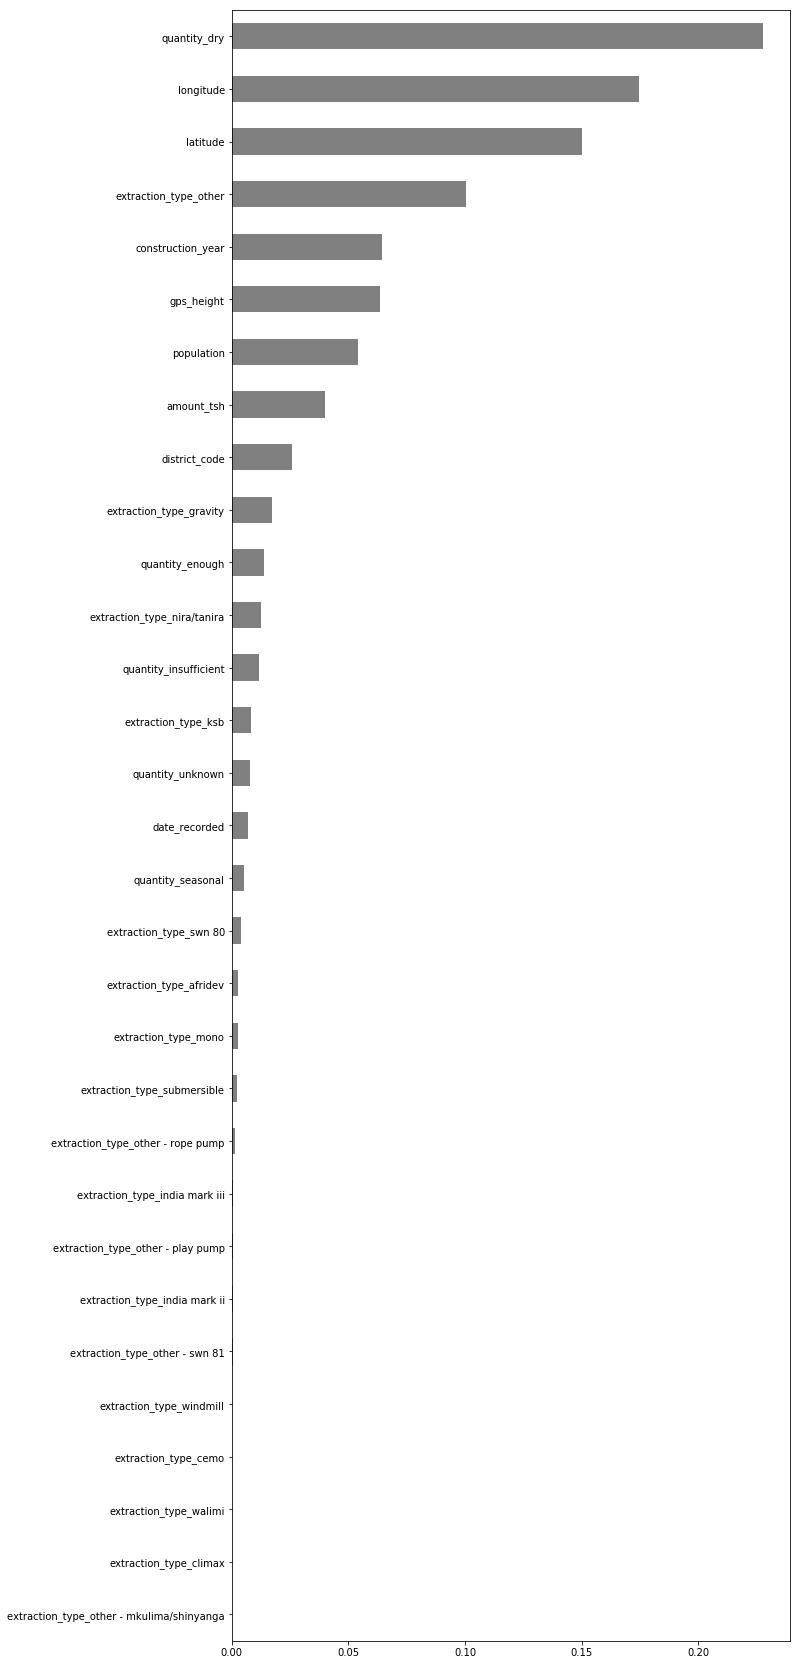

In [23]:
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.fit_transform(X_train).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');